# Exercise 2: 

Hypothesis 1: Whether there is a significant differnece based on different hyperparameters?

Hypothesis 2: the accuracy of model without validation set is significantly different from the model selected from the validations set.

In [5]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
data = load_iris()
X = data['data']
y = data['target']
print("Matrix dimension of X: ", X.shape)
print("Matrix dimension of y: ", y.shape)

Matrix dimension of X:  (150, 4)
Matrix dimension of y:  (150,)


## Random Forest

Have several hyperparameters, but we only focus on two of them:

1. `n_estimators`: the number of trees in the forest.
2. `max_depth`: the maximum depth of the tree.
3. `min_samples_split`: the minimum number of samples required to split an internal node.

We hypothesized that changing these two hyperparameters will significantly affect the accuracy of the model. Let's grid search these two hyperparameters and see if we can find a significant difference.


In [89]:
ls_n_estimators = [5, 100, 500]
ls_max_depth = [1, 3, 5]

In [92]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
ls_results = []
for n_estimators in ls_n_estimators:
    for max_depth in ls_max_depth:
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            clf.fit(x_train, y_train)
            ls_results.append([n_estimators, max_depth, clf.score(x_test, y_test)])

Text(47.25, 0.5, 'n_estimators')

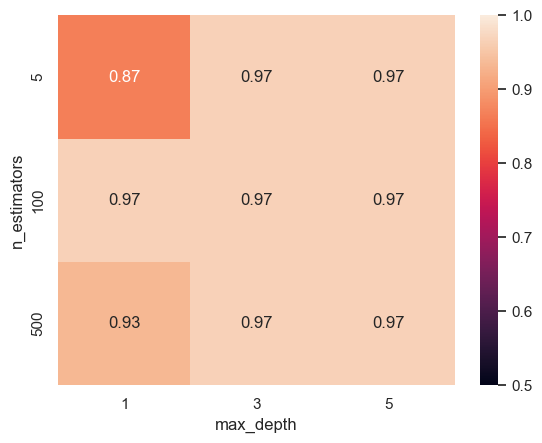

In [99]:
import numpy as np
heatmap_data = np.array(ls_results)[:, 2].reshape(len(ls_n_estimators), len(ls_max_depth))
heatmap_data
# visualize the heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid", palette="Set2")
sns.heatmap(heatmap_data,
            vmin=0.5, vmax=1.0, annot=True,
            # cbar=False,
            xticklabels=ls_max_depth, yticklabels=ls_n_estimators)
plt.xlabel('max_depth')
plt.ylabel('n_estimators')

In [104]:
diff_maxmin = []

for _ in range(100):
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ls_results = []
    for n_estimators in ls_n_estimators:
        for max_depth in ls_max_depth:
            clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
            clf.fit(x_train, y_train)
            ls_results.append([n_estimators, max_depth, clf.score(x_test, y_test)])
    scores = np.array(ls_results)[:, 2]
    # get the max and min difference
    diff_maxmin += [scores.max() - scores.min()]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [116]:
np.sum(np.array(diff_maxmin) > 0)

94

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1.0)

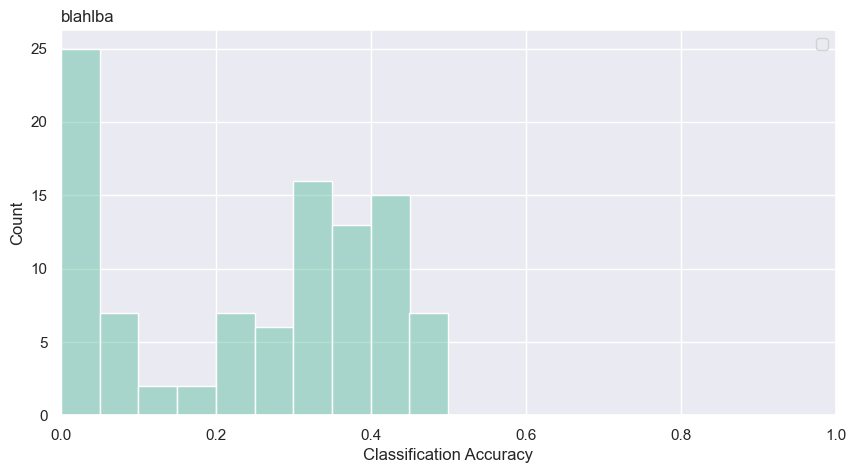

In [117]:
sns.set_theme(style="darkgrid", palette="Set2")
plt.figure(figsize=(10, 5))
sns.histplot(diff_maxmin, binwidth=.05, alpha=0.5)

# post-process the plot
plt.title("blahlba", loc="left")
plt.legend()
plt.xlabel("Classification Accuracy")
plt.xlim(0, 1)
# plt.ylim(0, 25)